## POS tagging using modified Viterbi

### Data Preparation

In [139]:
#Importing libraries
import nltk
nltk.download('treebank')
nltk.download('universal_tagset')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import re
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
import pprint

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [140]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [141]:
nltk_data[:3]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

In [142]:
# split data into training and validation set in the ratio 95:5

train_set,test_set = train_test_split(nltk_data,train_size=0.95,test_size=0.05,random_state = 101)

In [143]:
# create list of train and test tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
test_tagged_words = [tup[0] for sent in test_set for tup in sent]
print(len(train_tagged_words))
print(len(test_tagged_words))

95547
5129


In [144]:
# Let's have a look at the tagged words in the training set

train_tagged_words[:10]

[('Reliance', 'NOUN'),
 ('confirmed', 'VERB'),
 ('the', 'DET'),
 ('filing', 'NOUN'),
 ('but', 'CONJ'),
 ('would', 'VERB'),
 ("n't", 'ADV'),
 ('elaborate', 'VERB'),
 ('.', '.'),
 ('*', 'X')]

In [145]:
#looking at the tokens which were taged, from train_tagwords

train_tokens = [pair[0] for pair in train_tagged_words]
print(train_tokens[:10])

print("\n ---------------------------------------------------------------------------------------------------------------------------------------------------------------------- \n")

#looking at POS tags for the tokens in training set 

train_pos_tags = [pair[1] for pair in train_tagged_words]
print(train_pos_tags[:10])

['Reliance', 'confirmed', 'the', 'filing', 'but', 'would', "n't", 'elaborate', '.', '*']

 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------- 

['NOUN', 'VERB', 'DET', 'NOUN', 'CONJ', 'VERB', 'ADV', 'VERB', '.', 'X']


In [146]:
#creating a set of token owrd and pos tags

train_vocab_set = set(train_tokens)
train_pos_tag_set = set(train_pos_tags)

In [147]:
#To find out how many unique tags are present in training data 
tags = {tag for word,tag in train_tagged_words}

print("Info:- \nNumber of tags: {} \nNumber of words in Vocabulary: {}".format(len(train_pos_tag_set), len(train_vocab_set)))
print("\nThe tags available are :\n",train_pos_tag_set)

Info:- 
Number of tags: 12 
Number of words in Vocabulary: 12100

The tags available are :
 {'.', 'DET', 'NUM', 'ADP', 'CONJ', 'ADV', 'NOUN', 'ADJ', 'PRT', 'PRON', 'VERB', 'X'}


## 2. POS Tagging Algorithm - HMM

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 
In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). 
Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).


- P(w/t) is emission probability of a word given a tag.
  P(w/t) = count(w, t) / count(t). 


- P(t) is the probability of tag t given a previous tag. Its also called transition probability.


In [148]:
# computing P(w/t) and storing in T x V matrix
len_pos_tags = len(train_pos_tag_set)
len_vocab = len(train_vocab_set)
w_given_t = np.zeros((len_pos_tags, len_vocab))

In [149]:
#computing word given tag : i.e. Emission probability 

def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [150]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [151]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len_pos_tags, len_pos_tags), dtype='float32')
for i, t1 in enumerate(list(train_pos_tag_set)):
    for j, t2 in enumerate(list(train_pos_tag_set)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]



#converting matrix to dataframe 
tags_df = pd.DataFrame(tags_matrix, columns = list(train_pos_tag_set), index=list(train_pos_tag_set))

tags_df

,.,DET,NUM,ADP,CONJ,ADV,NOUN,ADJ,PRT,PRON,VERB,X
.,0.093320,0.173335,0.081003,0.091342,0.057538,0.052324,0.222242,0.043963,0.002427,0.066349,0.089095,0.026971
DET,0.017993,0.005676,0.022220,0.009540,0.000483,0.012438,0.638087,0.204323,0.000242,0.003744,0.039850,0.045405
NUM,0.117332,0.003276,0.184932,0.036033,0.013699,0.002978,0.350208,0.034247,0.026504,0.001489,0.018761,0.210542
ADP,0.039025,0.324709,0.062226,0.016893,0.000962,0.014006,0.320967,0.107024,0.001390,0.070031,0.008340,0.034427
CONJ,0.034868,0.121339,0.039981,0.052534,0.000465,0.055323,0.349140,0.118085,0.004649,0.058113,0.156671,0.008833
ADV,0.137131,0.069891,0.030474,0.118582,0.006956,0.080490,0.031467,0.129182,0.014243,0.014906,0.343491,0.023186
NOUN,0.240604,0.012942,0.009542,0.176514,0.042666,0.017074,0.263564,0.012248,0.043397,0.004607,0.147667,0.029175
ADJ,0.063931,0.004943,0.021256,0.078267,0.016971,0.004778,0.699621,0.066403,0.010710,0.000330,0.011699,0.021091
PRT,0.043822,0.097858,0.056672,0.020099,0.002306,0.010214,0.247776,0.083031,0.001647,0.017792,0.405272,0.013509
PRON,0.040965,0.009954,0.006508,0.022971,0.005360,0.034074,0.210949,0.073124,0.013017,0.007657,0.485452,0.089969


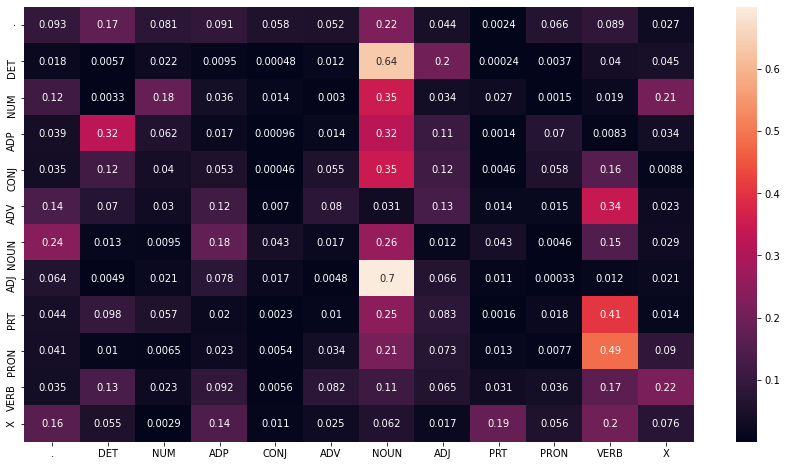

In [152]:
#plotting a heatmap for better visualisation

#T(i,j) -> P(tag j given tag i)

plt.figure(figsize=(15,8))
sns.heatmap(tags_df, annot=True)
plt.show()

### Build the vanilla Viterbi based POS tagger

In [153]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [154]:
# Running on entire test dataset would take more time
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]

test_run

[[('The', 'DET'),
  ('Contra', 'NOUN'),
  ('military', 'ADJ'),
  ('command', 'NOUN'),
  (',', '.'),
  ('in', 'ADP'),
  ('a', 'DET'),
  ('statement', 'NOUN'),
  ('from', 'ADP'),
  ('Honduras', 'NOUN'),
  (',', '.'),
  ('said', 'VERB'),
  ('0', 'X'),
  ('Sandinista', 'NOUN'),
  ('troops', 'NOUN'),
  ('had', 'VERB'),
  ('launched', 'VERB'),
  ('a', 'DET'),
  ('major', 'ADJ'),
  ('offensive', 'NOUN'),
  ('against', 'ADP'),
  ('the', 'DET'),
  ('rebel', 'NOUN'),
  ('forces', 'NOUN'),
  ('.', '.')],
 [('*-1', 'X'),
  ('Bucking', 'VERB'),
  ('the', 'DET'),
  ('market', 'NOUN'),
  ('trend', 'NOUN'),
  (',', '.'),
  ('an', 'DET'),
  ('issue', 'NOUN'),
  ('of', 'ADP'),
  ('$', '.'),
  ('130', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('general', 'ADJ'),
  ('obligation', 'NOUN'),
  ('distributable', 'ADJ'),
  ('state', 'NOUN'),
  ('aid', 'NOUN'),
  ('bonds', 'NOUN'),
  ('from', 'ADP'),
  ('Detroit', 'NOUN'),
  (',', '.'),
  ('Mich.', 'NOUN'),
  (',', '.'),
  ('apparently', 'ADV'),
  ('drew'

In [155]:
# now we will be tagging the test sentences 
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
diff = end-start

#accuracy 
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)

print("Time taken :", diff)
print("Accuracy for Vanilla Viterbi : ",accuracy*100)

Time taken : 28.413122177124023
Accuracy for Vanilla Viterbi :  89.38053097345133


In [156]:
# to check the incorrectly tagged words
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('The', 'DET'), (('Contra', '.'), ('Contra', 'NOUN'))],
 [('military', 'ADJ'), (('command', 'VERB'), ('command', 'NOUN'))],
 [('from', 'ADP'), (('Honduras', '.'), ('Honduras', 'NOUN'))],
 [('0', 'X'), (('Sandinista', '.'), ('Sandinista', 'NOUN'))],
 [('major', 'ADJ'), (('offensive', '.'), ('offensive', 'NOUN'))],
 [('the', 'DET'), (('rebel', '.'), ('rebel', 'NOUN'))],
 [('*-1', 'X'), (('Bucking', '.'), ('Bucking', 'VERB'))],
 [('apparently', 'ADV'), (('drew', '.'), ('drew', 'VERB'))],
 [('its', 'PRON'), (('Eveready', '.'), ('Eveready', 'NOUN'))],
 [('what', 'PRON'), (('*T*-252', '.'), ('*T*-252', 'X'))],
 [('*-1', 'X'), (('complaining', '.'), ('complaining', 'VERB'))],
 [('ended', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))]]


The accuracy for Vanilla viterbi is 89.3%

We can see that all the unknown words have been assigned "." as "." is the first tag in the list and its assigned whenevre the unknown word is encountered, since emission probability = 0 


In [157]:
#checking the unknown words

test_vocab_set = set([t for t in test_tagged_words])

unknown_words = list(test_vocab_set - train_vocab_set)
print("number of unknown words : ",len(unknown_words))
print("unknown words : ",unknown_words)

number of unknown words :  10
unknown words :  ['Honduras', 'Sandinista', 'offensive', 'drew', 'Bucking', 'Contra', 'complaining', 'rebel', 'Eveready', '*T*-252']


### Solve the problem of unknown words

### Viterbi Modification - Technique 1 

If the word isnt present in the training vocabulary , its emission probavility will be 0. 
In this case, the state probability will also be 0.

So, in the cases where the algorithm encounters the unknown word we can only consider the transition probability and leave out emission probability.

In [158]:
#In case of unknown words, we will use transition probbaility. (emission probability = 0)

def Viterbi_T1(words, train_bag = train_tagged_words):
  state = []
  T = list(set([pair[1] for pair in train_bag]))

  for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = []
        #for storing transition probabilities 
        p_transition = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            p_transition.append(transition_p)
         
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)]
        #if probability is 0, then we will be using transition probability
        if(pmax==0):
           pmax = max(p_transition)
           state_max = T[p_transition.index(pmax)]
        else:
           state_max = T[p.index(pmax)]

        state.append(state_max)
  return list(zip(words, state))

In [159]:
# now we will be tagging the test sentences 
start = time.time()
tagged_seq = Viterbi_T1(test_tagged_words)
end = time.time()
diff = end-start

#accuracy 
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)

print("Time taken :", diff)
print("Accuracy for Viterbi - technique 1 : ",accuracy*100)

Time taken : 26.20182180404663
Accuracy for Viterbi - technique 1 :  94.69026548672566


In [160]:
# let's check the incorrectly tagged words
inc_case1 = [j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]
inc_case1

[(('command', 'VERB'), ('command', 'NOUN')),
 (('Honduras', 'DET'), ('Honduras', 'NOUN')),
 (('Sandinista', 'VERB'), ('Sandinista', 'NOUN')),
 (('Eveready', 'VERB'), ('Eveready', 'NOUN')),
 (('*T*-252', 'VERB'), ('*T*-252', 'X')),
 (('up', 'ADV'), ('up', 'PRT'))]

The following words have been correctly tagged by the Modification Technique 1 when compared to vanilla viterbi 

1. Contra - correctly tagged as NOUN
2. military - correctly tagged as adjective 
3. offensive - correctly tagged as NOUN
4. The - correclty tagged as Det
5. Bucking - correctly tagged VERB
6. its- Correctly tagged as PRON
7. complaining- Correctly tagged as VERB
 

### Viterbi Modification technique 2 

- We can use a rule based tagger as a back off when the Viterbi algorothm is not able to classify an unknown word.

The rule based tagger is defined as follows:

In [161]:
#patterns for tagging are specified as follows.

patterns = [
    (r'[aA-zZ]+(ed|ing|es)$','VERB'), #word ending with ing, ed, es is a verb
    (r'.*\'s$', 'NOUN'),              #possesive noun
    (r'.*s$', 'NOUN'),                #plural noun
    (r'\*T?\*?-[0-9]+$', 'X'),        #special character conbination
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), #number
    (r'.*', 'NOUN')                   #nouns  
]

#rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

In [162]:
# Incase unknown words are encountered , it will be backoff to rule based tagger.

def Viterbi_T2(words, train_bag = train_tagged_words):
  state = []
  T = list(set([pair[1] for pair in train_bag]))

  for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
                     
        pmax = max(p)
        state_max = rule_based_tagger.tag([word])[0][1]

        if(pmax==0):
            state_max = rule_based_tagger.tag([word])[0][1] #it will tag based on the rule based tagger
        else:
            if state_max != 'X':
                # getting state for which probability is maximum
                state_max = T[p.index(pmax)]

        state.append(state_max)
  return list(zip(words, state))

In [163]:
# now we will be tagging the test sentences 
start = time.time()
tagged_seq = Viterbi_T2(test_tagged_words)
end = time.time()
diff = end-start

#accuracy 
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)

print("Time taken :", diff)
print("Accuracy for Viterbi - technique 2 : ",accuracy*100)

Time taken : 29.47772741317749
Accuracy for Viterbi - technique 2 :  97.34513274336283


In [164]:
# let's check the incorrectly tagged words
[j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]


[(('command', 'VERB'), ('command', 'NOUN')),
 (('drew', 'NOUN'), ('drew', 'VERB')),
 (('up', 'ADV'), ('up', 'PRT'))]

 The cases which were incorreclty tagged and got corrected after Viterbi modification technique 2 are as follows:
- Honduras- 'NOUN'
- Sandinista- 'NOUN'
- Eveready - 'NOUN'
- *T*-252 - 'X'

#### Evaluating tagging accuracy

In [165]:
#list of untagged words from teh test set
test_tagged_words = [tup[0] for sent in test_set for tup in sent]

#list of tagged words
test_run_base = [tup for sent in test_set for tup in sent]

Accuracy of Vanilla Viterbi On Test set

In [166]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Vanilla Viterbi Algorithm Accuracy: ',accuracy*100)

Time taken in seconds:  1140.3728566169739
Vanilla Viterbi Algorithm Accuracy:  90.9728992006239


Accuracy of Viterbi Modification -Technique 1 on test set

In [167]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_T1(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Modified Viterbi Algorithm Accuracy - Technique1: ',accuracy*100)

Time taken in seconds:  1162.870013475418
Modified Viterbi Algorithm Accuracy - Technique1:  94.03392474166505


Accuracy of Viterbi modification - Technique 2 on test set

In [168]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_T2(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Modified Viterbi Algorithm Accuracy - Technique2: ',accuracy*100)

Time taken in seconds:  1194.010978937149
Modified Viterbi Algorithm Accuracy - Technique2:  95.3987131994541


####Test tagging acccuracies on sample test sentences given:


In [169]:
sample_sentences_test = [ "Android is a mobile operating system developed by Google.",
"Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.",
"Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
"Twitter is an online news and social networking service on which users post and interact with messages known as tweets.",
"Before entering politics, Donald Trump was a domineering businessman and a television personality.",
"The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.",
"This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.",
"Show me the cheapest round trips from Dallas to Atlanta",
"I would like to see flights from Denver to Philadelphia.",
"Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.",
"NASA invited social media users to experience the launch of ICESAT-2 Satellite."
]

In [170]:
#getting list of untagged worsd
sample_test_words = [word for sent in sample_sentences_test for word in sent.split()]

#tagging the test sentences with vanilla viterbi, to verify if modification works
start = time.time() 
sample_tagged_seq = Viterbi(sample_test_words)
end = time.time()
difference = end-start

print("Time taken: ",difference)

sample_tagged_seq

Time taken:  38.628395080566406


[('Android', '.'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google.', '.'),
 ('Android', '.'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', '.'),
 ('worldwide', '.'),
 ('on', 'ADP'),
 ('smartphones', '.'),
 ('since', 'ADP'),
 ('2011', '.'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013.', '.'),
 ('Google', '.'),
 ('and', 'CONJ'),
 ('Twitter', '.'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', '.'),
 ('that', 'DET'),
 ('gave', 'VERB'),
 ('Google', '.'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ("Twitter's", '.'),
 ('firehose.', '.'),
 ('Twitter', '.'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', '.'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOUN'),
 ('on', 'ADP'),
 ('which', 'DET'),
 ('users', 'NOUN'),
 ('post', 'NOUN'),
 ('

- We can see that some of the unknown words have been misclassifed by vanilla viterbi.They are as follows:
  - 'Android', '.'
  - 'Cup', '.'
  - Google', '.'
  - OS', '.'),
  - 'worldwide', '.'  and so on..

 We will verify if they are tagged correctly by using the modified viterbi as follows:

In [171]:
#tagging the test sentences with modified viterbi
start = time.time() 
sample_tagged_seq = Viterbi_T2(sample_test_words)
end = time.time()
difference = end-start

print("Time taken: ",difference)

sample_tagged_seq

Time taken:  37.66370248794556


[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google.', 'NOUN'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'VERB'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013.', 'NOUN'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ("Twitter's", 'NOUN'),
 ('firehose.', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOUN'),
 ('on', 'ADP'),
 ('which', 'DET

The following unknown words have been correctly identified as noun
 - ('Google.', 'NOUN'),
 - ('Android', 'NOUN'),
 - ('OS', 'NOUN'),
 - ('worldwide', 'NOUN'),
 - ('Twitter', 'NOUN'),
 - ('Google', 'NOUN'),

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

Accuracy ::

1. Vanilla Viterbi = 90.97
2. Modified Viterbi Technique 1 = 94.03
3. Modified Viterbi Technique 2 = 95.39

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

The cases which were incorreclty tagged and got corrected after modification are as follows:
- The -  'DET'
- Contra- 'NOUN'
- Honduras- 'NOUN'
- Sandinista- 'NOUN'
- major - 'ADJ'
- offensive - 'NOUN'
- Bucking - 'VERB'
- apparently - 'ADV'
- its - 'PRON'
- Eveready - 'NOUN'
- what - 'PRON'
- *T*-252 - 'X'
- complaining - 'VERB',
- ended - 'VERB'


### Conclusion :

 We can see from above that most of the words which were wrongly tagged by Vanilla Viterbi were corrected by Viterbi algorithm backed off by rule based tagger

 The two techniques used for modification of vanilla viterbi are as follows:
 - Technique 1 
   - We used Transition probability for unknown words.
   - This method gave us test accuracy of 94.03% but there were still classiffication which was incorrect.

 - Technique 2
   - We used Viterbi algorithm and bakced it up by rule based tagger.
   - This technique gave us the test accuracy of 95.39%